# 1. 라이브러리 로드

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk

bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
!pip install bertopic mecab-python3 konlpy JPype1-py3 sentence_transformers

In [16]:
import re

import pandas as pd

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from konlpy.tag import Mecab
from bertopic import BERTopic

import matplotlib.pyplot as plt
import seaborn as sns

# 2. 데이터 로드

In [3]:
refined_news_df = pd.read_csv('/content/drive/MyDrive/estate_volume_analysis/refined_news_summary.csv', index_col=0)
refined_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17075 entries, 0 to 17074
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 17075 non-null  object
 1   link                  17075 non-null  object
 2   article               17075 non-null  object
 3   date                  17075 non-null  object
 4   media                 17075 non-null  object
 5   region_code           17075 non-null  int64 
 6   region                17075 non-null  object
 7   district              17075 non-null  object
 8   yyyymm                17075 non-null  object
 9   text_length           17075 non-null  int64 
 10  text_token_length     17075 non-null  int64 
 11  article_summary       17075 non-null  object
 12  preprocessed_article  17075 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.8+ MB


In [4]:
article_list = refined_news_df['article'].tolist()
article_list[:2]

['최소 입찰 예정가격 86억1298만원서울 강남구 \'노른자위 땅\'에서 10년 넘게 방치되던 옛 삼성2 파출소 건물과 땅이 부동산 시장에 매물로 나왔다.29일 서울시는 최근 시유재산 매각 공고를 내고 과거 파출소로 쓰이던 강남구 삼성동 114-6번지 건물과 땅을 일반 경쟁입찰 방식으로 매각한다고 밝혔다.공실 건물 133.03㎡, 토지 124.0㎡다. 일반상업지역에 속해 있다. 최소 입찰 예정가격은 86억1298만원이다.접수 마감은 10월 4일이다. 입찰 예정가격보다 높은 가격을 써낸 이들 가운데 최고가를 부른 이가 낙찰자가 된다.서울 강남구 삼성동 114-6번지 현재 모습[사진=서울시]이곳은 지하철 9호선과 수인 분당선이 지나가는 선정릉역 인근이다. 원래 파출소로 쓰였지만, 지하철 9호선 공사가 한창이던 2013년 건물 곳곳에 균열이 생기면서 붕괴 우려가 나왔고 결국 그 해 파출소가 이전했다.9호선 시공사인 경남기업이 도산하면서 건물 균열 보상 역시 받을 수 없게 되면서, 철거되지 않은 채 10년 넘게 그대로 방치됐다.시 관계자는 "민간에서 활용할 가치가 높다고 판단했으며 입찰 예정가격은 감정평가를 거쳐 선정했다"고 말했다.',
 '2015년~2024년 9월 1일까지 서울시 싱크홀 233건 중강남구 28건 가장多…이어 송파 23건 영등포 16건 순상·하수관 노후와 손상이 주요 원인인 가운데“싱크홀 예방을 위한 인력·장비 늘려야”[이데일리 박지애 기자] 지난 10년간 서울에서 땅꺼짐(싱크홀) 사고가 200건 넘게 발생한 가운데 강남구의 발생건수가 가장 많은 것으로 나타났다.싱크홀이 발생한 대부분의 원인이 상·하수관 손상이나 노후화 등 관리부실로 알려지며 사고 예방을 위한 관리 체계와 인력 보강이 시급하단 지적이다.지난달 29일 오전 서울 서대문구 연희동 성산로에서 발생한 땅 꺼짐(싱크홀) 현상 현장에서 경찰 및 소방 관계자들이 사고 폭을 측정하고 있다.(사진=연합뉴스)싱크홀은 지반침하 종류 중에서도 침하→함몰→공동 다음 단계로 하부 지반이 사라지며 지표층이 

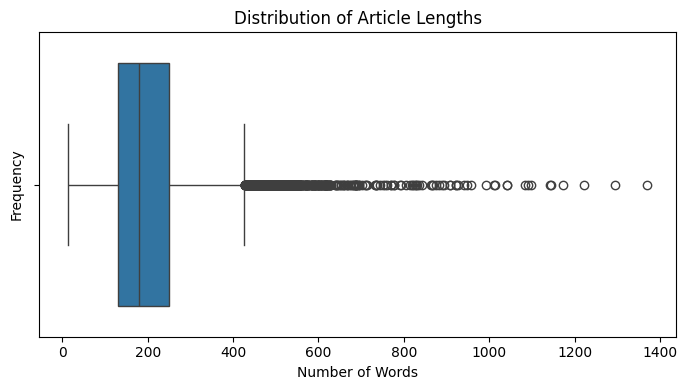

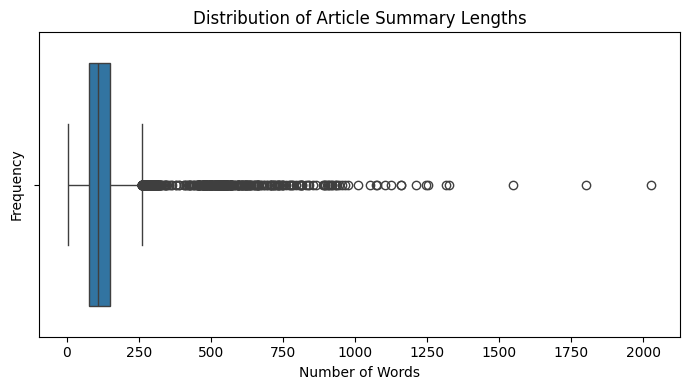

,article_len,article_summary_len
count,17075.000000,17075.000000
mean,203.821728,125.577862
std,107.846880,90.203282
min,14.000000,5.000000
25%,131.000000,77.000000
50%,180.000000,108.000000
75%,249.000000,150.000000
max,1370.000000,2026.000000


In [30]:
# 기사 원문 vs 요약문 단어 분포 차이
refined_news_df['article_len'] = refined_news_df['article'].apply(lambda x: len(x.split()))
refined_news_df['article_summary_len'] = refined_news_df['article_summary'].apply(lambda x: len(x.split()))

# Plot for Article Length
plt.figure(figsize=(7, 4))
sns.boxplot(x=refined_news_df['article_len'])
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.tight_layout()
plt.show()

# Plot for Article Summary Length
plt.figure(figsize=(7, 4))
sns.boxplot(x=refined_news_df['article_summary_len'])
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Article Summary Lengths')
plt.tight_layout()
plt.show()

refined_news_df[['article_len', 'article_summary_len']].describe()

# 3. 데이터 전처리

In [7]:
mecab = Mecab()

In [8]:
stopwords_file = open('/content/drive/MyDrive/estate_volume_analysis/stopwords-ko.txt')
stopwords = stopwords_file.readlines()
stopwords = [word.rstrip() for word in stopwords]
len(stopwords)

595

In [63]:
# 신문사, 행정구 명 제거
media_list = refined_news_df['media'].unique().tolist()
region_list = [region[:2] for region in refined_news_df['region'].unique().tolist()]
region_list2 = refined_news_df['region'].unique().tolist()
others = ['서울', '경기', '기자', '머니', '투데이', '트위터', '자료', '사진',
          '서울시', '아시아', '뉴스', '있는', '구는', '지난', '박종일', '구청장', '위해', '보는',
          '박영석', '아파트', '주택', '댓글', '오피스텔', '지역', '마곡', '부동산', '올해', '했다', '다'
        ]

stopwords_with_media_region = stopwords + media_list + region_list + region_list2 + others
len(stopwords_with_media_region)

722

In [64]:
def preprocess_text_mecab(text):

    # 1. 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text)

    # 2. 명사 추출
    tokens = mecab.pos(text)

    # 3. 불용어 필터링
    tokens = [token for token, pos in tokens if token not in stopwords_with_media_region and len(token) > 1 and pos == 'NNG']

    return " ".join(tokens)


refined_news_df['preprocessed_article'] = refined_news_df['article'].apply(preprocess_text_mecab)
refined_news_df['preprocessed_article_summary'] = refined_news_df['article_summary'].apply(preprocess_text_mecab)

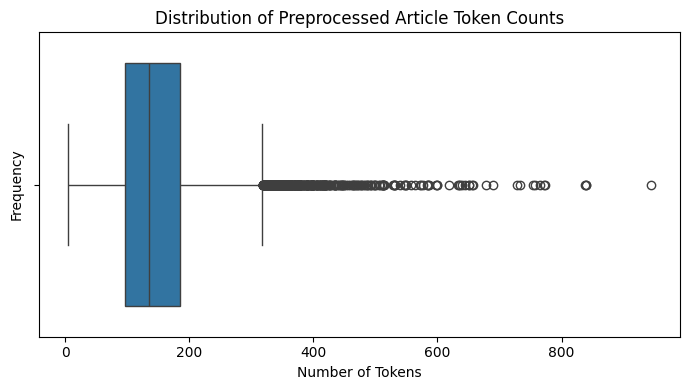

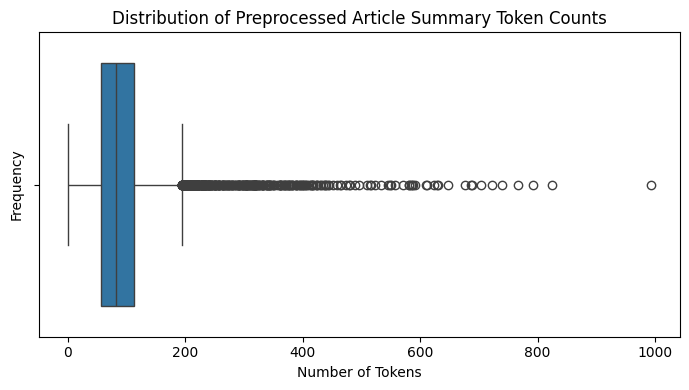

,preprocessed_article_len,preprocessed_article_summary_len
count,17075.000000,17075.000000
mean,148.530659,90.302020
std,74.868610,53.447199
min,5.000000,1.000000
25%,97.000000,57.000000
50%,135.000000,82.000000
75%,185.000000,112.000000
max,944.000000,993.000000


In [65]:
# 전처리 후 기사 원문 vs 요약문 단어 분포 차이
refined_news_df['preprocessed_article_len'] = refined_news_df['preprocessed_article'].apply(lambda x: len(x.split()))
refined_news_df['preprocessed_article_summary_len'] = refined_news_df['preprocessed_article_summary'].apply(lambda x: len(x.split()))

# Plot for Article Length
plt.figure(figsize=(7, 4))
sns.boxplot(x=refined_news_df['preprocessed_article_len'])
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Preprocessed Article Token Counts')
plt.tight_layout()
plt.show()

# Plot for Article Summary Length
plt.figure(figsize=(7, 4))
sns.boxplot(x=refined_news_df['preprocessed_article_summary_len'])
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Preprocessed Article Summary Token Counts')
plt.tight_layout()
plt.show()

refined_news_df[['preprocessed_article_len', 'preprocessed_article_summary_len']].describe()

# 4. Topic Modeling

In [66]:
class CustomTokenizer:

    def __init__(self, tagger):

        self.tagger = tagger

    def __call__(self, sent):

        # sent = re.sub(r'[A-Za-z0-9]', '', sent)  # 영어와 숫자 제거
        sent = re.sub(r'[^\w\s]', '', sent)      # 특수문자 제거

        word_tokens = self.tagger.pos(sent)
        result = [word for word, pos in word_tokens if len(word) > 1 and pos == 'NNG']

        return result


custom_tokenizer = CustomTokenizer(mecab)

In [67]:
# 단어 빈도수 추출
# 텍스트 데이터로부터 특징 추출 위함
vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=112, # 전처리 이후 토큰 수 Q3 값으로 설정
    stop_words=stopwords_with_media_region,
)

vectorizer

CountVectorizer(max_features=112,
                stop_words=['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면',
                            '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것',
                            '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서',
                            '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로',
                            '곧', '공동으로', '과', ...],
                tokenizer=<__main__.CustomTokenizer object at 0x7c8cd09d2d70>)

In [35]:
# # counter vectorizer fitting
# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, stop_words=stopwords_with_media_region)
# X = vectorizer.fit_transform(refined_news_df['article'])

# # 단어 빈도 계산
# word_freq = X.toarray().sum(axis=0)
# sorted_freq = sorted(word_freq, reverse=True)

# # 히스토그램 그리기
# plt.plot(sorted_freq)
# plt.title("Word Frequency Distribution")
# plt.xlabel("Words (Ranked)")
# plt.ylabel("Frequency")
# plt.show()

In [71]:
# base_embedding_model = 'all-MiniLM-L6-v2'
news_embedding_model =  SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

model = BERTopic(
    language="multilingual",
    embedding_model=news_embedding_model,
    vectorizer_model=vectorizer,
    nr_topics=20,
    top_n_words=20,
    calculate_probabilities=True,
    verbose=True
)

In [72]:
topics, probs = model.fit_transform(refined_news_df['article_summary'])

2024-12-04 15:33:37,051 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/534 [00:00<?, ?it/s]

2024-12-04 15:35:20,820 - BERTopic - Embedding - Completed ✓
2024-12-04 15:35:20,822 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-04 15:35:26,212 - BERTopic - Dimensionality - Completed ✓
2024-12-04 15:35:26,214 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-04 15:36:30,451 - BERTopic - Cluster - Completed ✓
2024-12-04 15:36:30,454 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-04 15:36:48,936 - BERTopic - Representation - Completed ✓
2024-12-04 15:36:48,937 - BERTopic - Topic reduction - Reducing number of topics
2024-12-04 15:37:06,357 - BERTopic - Topic reduction - Reduced number of topics from 288 to 20


In [73]:
topic_info_df = model.get_topic_info()
topic_info_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7083,-1_사업_계획_구역_가구,"[사업, 계획, 구역, 가구, 정비, 주민, 개발, 도시, 시설, 지구, 추진, 조...",[\n 서울 강동구 고덕동 옛 서울승합차고지가 대형 복합단지로 탈바꿈한다. 이는 서...
1,0,3547,0_개발_구역_계획_정비,"[개발, 구역, 계획, 정비, 사업, 지구, 부지, 도시, 시설, 위원회, 건축, ...",[있다. 장시복 1-4구역'에 주상복합 7개동 1031가구 들어서]영등포 재래시장 ...
2,1,2004,1_지원_사업_교육_주민,"[지원, 사업, 교육, 주민, 참여, 대상, 공동, 운영, 복지, 마을, 평가, 사...",[한다. 사업 발굴 및 실행 등 2개 분야총 8건 지원...건당 200만~500만원...
3,2,1201,2_주차장_설치_안전_공사,"[주차장, 설치, 안전, 공사, 주민, 대상, 건물, 실시, 관리, 개선, 조사, ...",[있다.\n ‘창신·숭인 도시재생지역 계단 정비 공사’ 정두리 종로구는 낡고 위험해...
4,3,1020,3_도서관_어린이_공원_조성,"[도서관, 어린이, 공원, 조성, 주민, 공간, 운영, 문화, 참여, 오후, 이용,...",[했다. = = 서울 강서구(구청장 노현송)는 단순히 도서대출과 열람에 머물고 주민...
5,4,549,4_토지_서비스_도로_정보,"[토지, 서비스, 도로, 정보, 신청, 구청, 조사, 건물, 경우, 가격, 주민, ...",[있다.\n 김영배 성북구청장5월29~6월30일 이의신청 접수 및 감정평가사 박종일...
6,5,508,5_가격_분양_거래_전용,"[가격, 분양, 거래, 전용, 가구, 공급, 재건축, 시장, 면적, 이후, 입주, ...",[있다. [세계파이낸스]수도권 주택시장의 장기침체가 곧 끝나간다는 이른바 집값 '바...
7,6,353,6_시설_지상_센터_규모,"[시설, 지상, 센터, 규모, 건립, 지하, 주민, 주차장, 복지, 공간, 조성, ...",[\n 10월13일 신청사 개청식 개최 ... 양질의 행정 서비스 박종일 동대문구(...
8,7,180,7_설치_가구_지원_사용,"[설치, 가구, 지원, 사용, 대상, 환경, 선정, 평가, 사업, 신청, 생활, 건...",[\n 서울 서울 노원구(구청장 김성환)는 오는 31일까지 베란다 미니태양광 설치 ...
9,8,156,8_시장_가격_개선_시설,"[시장, 가격, 개선, 시설, 지원, 운영, 대상, 지정, 구청, 참여, 선정, 평...","[있다. 중곡시장 고객쉼터 조감도광진구, 오는 21일 ‘중곡전통시장 고객쉼터’ 준공..."


In [74]:
model.visualize_topics()

In [75]:
print(probs[0])
model.visualize_distribution(probs[0])

[5.71252427e-01 5.30947650e-02 3.14403547e-02 1.67559499e-02
 1.86575572e-02 2.93527865e-02 2.06025690e-02 5.75753396e-03
 6.23903228e-03 3.35051464e-03 9.71153596e-03 5.75092454e-03
 1.20758489e-03 5.03596544e-03 1.80003507e-03 5.22697463e-04
 1.40167257e-03 8.32293656e-04 9.65593778e-04]


In [76]:
for i in range(0, 10):
  print(i,'번째 토픽 :', model.get_topic(i))

0 번째 토픽 : [('개발', 0.04882451806890712), ('구역', 0.0471427615138267), ('계획', 0.047075682836402864), ('정비', 0.039924625866541046), ('사업', 0.03760211074984821), ('지구', 0.03477777301895407), ('부지', 0.03115053861471327), ('도시', 0.03002101825692366), ('시설', 0.02966116514216741), ('위원회', 0.029222253187149983), ('건축', 0.029042920486392877), ('결정', 0.026709476410325072), ('가구', 0.026508212409479974), ('규모', 0.026485752063162067), ('추진', 0.025546121928370427), ('예정', 0.024924282244593622), ('지정', 0.023838376187954376), ('단위', 0.022545258526813525), ('지하', 0.022032654049561153), ('변경', 0.0216785027339918)]
1 번째 토픽 : [('지원', 0.07736017548159785), ('사업', 0.05395983315116553), ('교육', 0.048564698053337414), ('주민', 0.045060169608938244), ('참여', 0.041025706176606516), ('대상', 0.03962624344410207), ('공동', 0.039380782701198956), ('운영', 0.039144537837864604), ('복지', 0.03898862263886415), ('마을', 0.03846517857328906), ('평가', 0.03612118314398334), ('사회', 0.03413893965183466), ('학교', 0.03342529644788108), ('기업'

In [77]:
refined_news_df['topic'] = topics
refined_news_topic_df = refined_news_df.merge(topic_info_df[['Topic', 'Name', 'Representation']], left_on='topic', right_on='Topic')
refined_news_topic_df['Name'].value_counts()

,count
Name,
-1_사업_계획_구역_가구,7083
0_개발_구역_계획_정비,3547
1_지원_사업_교육_주민,2004
2_주차장_설치_안전_공사,1201
3_도서관_어린이_공원_조성,1020
4_토지_서비스_도로_정보,549
5_가격_분양_거래_전용,508
6_시설_지상_센터_규모,353
7_설치_가구_지원_사용,180


In [79]:
# refined_news_topic_df.to_csv('refined_news_topic.csv', encoding='utf-8-sig')